# 파이토치 MNIST 모델

## modules import 

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

## 전처리 설정
- `transform.Compose`

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, ), (0.5, ))])

## 데이터 로드 및 데이터 확인

In [4]:
trainset = torchvision.datasets.MNIST(root = './data',
                                      train = True,
                                      download = True,
                                      transform = transform)

testset = torchvision.datasets.MNIST(root = './data',
                                      train = False,
                                      download = True,
                                      transform = transform)



Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
train_loader = DataLoader(trainset,
                          batch_size = 128,
                          shuffle = True,
                          num_workers = 2)

test_loader = DataLoader(testset,
                         batch_size = 128,
                         shuffle = False,
                         num_workers = 2)

In [6]:
image, label = next(iter(train_loader))

In [7]:
image.shape, label.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [8]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    fig = plt.figure(figsize = (10, 5))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

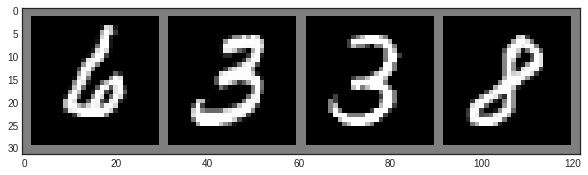

In [9]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images[:4]))

## 신경망 구성

In [16]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s

        return num_features

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


- `.parameters()` 

In [17]:
params = list(net.parameters())
print(len(params))
print(params[0].size())

10
torch.Size([6, 1, 3, 3])


임의의 값을 넣어 forward값 확인

In [18]:
input = torch.randn(1, 1, 28, 28)
out = net(input)
print(out)

tensor([[-0.0849, -0.0782,  0.0089,  0.0324,  0.0102,  0.0550,  0.0707, -0.0284,
         -0.0757,  0.0362]], grad_fn=<AddmmBackward>)


## 손실함수와 옵티마이저

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001,
                      momentum = 0.9)

## 모델 학습

- `optimizer.zero_grad` : 가중치의 그래디언트 초기화

- loss 계산

- `loss.backward()`

- `optmizer.step()` : 업데이트

- 배치수 확인

In [20]:
total_batch = len(train_loader)
print(total_batch)

469


- 설명을 위해 `epochs=2`로 지정

In [22]:
for epoch in range(2):

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data

        optimizer.zero_grad() # 매개변수 0 초기화
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward() # 백워드 수행
        optimizer.step() # 옵티마이저 다음 스텝 수행

        running_loss += loss.item() # 1개의 값을 더함
        if i % 100 == 99:
            print("Epoch: {}, Iter: {}, Loss: {}".format(epoch+1, i + 1, running_loss/2000))
            running_loss = 0.0 # 초기화



Epoch: 1, Iter: 100, Loss: 0.11332166397571564
Epoch: 1, Iter: 200, Loss: 0.11204529809951783
Epoch: 1, Iter: 300, Loss: 0.10924388015270234
Epoch: 1, Iter: 400, Loss: 0.10104553896188737
Epoch: 2, Iter: 100, Loss: 0.05462932616472244
Epoch: 2, Iter: 200, Loss: 0.03567540092766285
Epoch: 2, Iter: 300, Loss: 0.027508971109986305
Epoch: 2, Iter: 400, Loss: 0.022463487982749938


## 모델의 저장 및 로드

- `torch.save`
  - `net.state_dict()`를 저장

- `torch.load`
  - `load_state_dict`로 모델을 로드

In [23]:
PATH = './mnist_net.pth'
torch.save(net.state_dict(), PATH) # state_dict를 path에 저장

In [24]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [25]:
net.parameters

<bound method Module.parameters of Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)>

## 모델 테스트

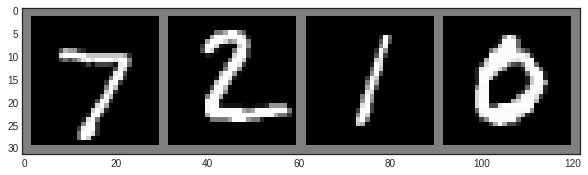

In [26]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images[:4]))

In [27]:
outputs = net(images)

In [28]:
_, predicted = torch.max(outputs, 1)
print(predicted)

tensor([7, 2, 1, 0, 4, 1, 4, 9, 6, 9, 0, 6, 9, 0, 1, 5, 9, 7, 5, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 6, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        9, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 7, 7, 8, 4, 3, 7, 4, 2, 4, 3, 0, 7, 0,
        2, 7, 1, 7, 3, 7, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 4, 3, 1, 4,
        1, 9, 6, 9, 6, 0, 5, 4, 9, 9, 2, 1, 9, 4, 8, 7, 3, 9, 7, 4, 4, 4, 9, 2,
        5, 4, 7, 6, 4, 9, 0, 5])


In [29]:
print("".join("{}\t".format(str(predicted[j].numpy())) for j in range(4)))

7	2	1	0	


In [30]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(100 * correct / total)

89.43


## GPU 설정 후 학습
- 설정 후, 모델과 데이터에 `to`로 GPU를 사용 가능한 형태로 변환 해줘야 한다.

- `.cuda()` 로도 가능

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

- 현재 GPU 설정

In [2]:
torch.cuda.is_available() # 사용가능한지 물어봄

True

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

In [5]:
device

device(type='cuda')

- 데이터 로드


In [6]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, ), (0.5, ))])

trainset = torchvision.datasets.MNIST(root = './data',
                                      train = True,
                                      download = True,
                                      transform = transform)

testset = torchvision.datasets.MNIST(root = './data',
                                      train = False,
                                      download = True,
                                      transform = transform)

train_loader = DataLoader(trainset,
                          batch_size = 128,
                          shuffle = True,
                          num_workers = 2)

test_loader = DataLoader(testset,
                         batch_size = 128,
                         shuffle = False,
                         num_workers = 2)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


- 모델 생성

In [7]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s

        return num_features

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [8]:
net = Net().to(device) # cuda로 모델생성하여 보냄

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9)

In [10]:
for epoch in range(2):

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device) # cuda로 넘김

        optimizer.zero_grad() # 매개변수 0 초기화
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward() # 백워드 수행
        optimizer.step() # 옵티마이저 다음 스텝 수행

        running_loss += loss.item() # 1개의 값을 더함
        if i % 100 == 99:
            print("Epoch: {}, Iter: {}, Loss: {}".format(epoch+1, i + 1, running_loss/2000))
            running_loss = 0.0 # 초기화



Epoch: 1, Iter: 100, Loss: 0.11507981383800507
Epoch: 1, Iter: 200, Loss: 0.11467995154857635
Epoch: 1, Iter: 300, Loss: 0.11417056369781495
Epoch: 1, Iter: 400, Loss: 0.11327291166782379
Epoch: 2, Iter: 100, Loss: 0.10971651244163513
Epoch: 2, Iter: 200, Loss: 0.10200332927703858
Epoch: 2, Iter: 300, Loss: 0.08084120607376098
Epoch: 2, Iter: 400, Loss: 0.05326758170127869


In [11]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(100 * correct / total)

82.47
